In [8]:
import numpy as np
import smplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import scipy
import scipy.optimize as opt
import functools
from scipy.optimize import minimize, least_squares
from scipy.constants import e, h, hbar, alpha, c, m_e
# A bunch of constants factored into a single variable. This is half the classical electron radius
f = (hbar * alpha / m_e / c)**2 / 2

# A grid of scattering angles in rad.
theta = np.arange(25, 150, 0.01)
n = len(theta)

# factor to take degrees to radians because its stupid
d = np.pi/180
E = 0.0175 #in MeV
ad = pd.read_excel('AtomicFormParams.xlsx')
ad.index=[1,6,8,27,62]
#print(aD)


# plot experimental data
x = [] # thetas
y = [] # counts
z = [] # errors

with open('Carbonv2.csv') as File:  
    Line_reader = csv.reader(File, delimiter=',')
    for row in Line_reader:
        x.append(float(row[0]))
        y.append(float(row[1]))
        z.append(float(row[2]))

x = x[1:]
y = y[1:]
z = z[1:]

# functions for the (uncorrected) KN and Thompson cross sections as a function of energy and scattering angle(in degrees)
def KleinNishina(E,phi):
    nu = E * 1.e6 * e / h
    lam = c / nu
    lamp = lam + h / m_e / c * (1 - np.cos(phi*d))
    P = lam / lamp
    dsigma_dOmegaKN = f * P**2 * (P + 1/P - np.sin(phi*d)**2) 
    return dsigma_dOmegaKN

def Thompson(phi):
    dsigma_dOmegaR = f * (1 + np.cos(phi*d)**2) 
    return dsigma_dOmegaR

# functions to compute the Atomic form factor F

def F(theta, Z):
    # some variable definitions
    f = np.zeros(len(theta))
    for i,theta in enumerate(theta):
        x = 41.2148 * (E/(0.511)) * np.sin(d*0.5*theta)
        q = 2*E/c * np.sin(d*theta/2)
        a = (Z - (5/16))*alpha
        gamma = (1-a**2)**0.5
        Q = q / (2*m_e*c*a)
        f_temp = Z*(1 + ad.at[Z,'a1']*x**2 + ad.at[Z,'a2']*x**3 + ad.at[Z,'a3']*x**4)/(1 + ad.at[Z,'a4']*x**2 + ad.at[Z,'a5']*x**4)**2
        if Z>10 and f_temp < 2:
            F_k = (np.sin(2*gamma*np.arctan(Q)))/(gamma*Q*(1+Q**2)**gamma)
            f[i] = F_k
        else:
            f[i] = f_temp
    return f

# atomic form factor for one-off calculations (one theta at a time)

def Fone(theta, Z):
    # some variable definitions
    x = 41.2148 * (E/(0.511)) * np.sin(d*0.5*theta)
    q = 2*E/c * np.sin(d*theta/2)
    a = (Z - (5/16))*alpha
    gamma = (1-a**2)**0.5
    Q = q / (2*m_e*c*a)
    f = Z*(1 + ad.at[Z,'a1']*x**2 + ad.at[Z,'a2']*x**3 + ad.at[Z,'a3']*x**4)/(1 + ad.at[Z,'a4']*x**2 + ad.at[Z,'a5']*x**4)**2
    if Z>10 and f < 2:
        F_k = (np.sin(2*gamma*np.arctan(Q)))/(gamma*Q*(1+Q**2)**gamma)
        return max(f,F_k)
    else:
        return f
    
# atomic form factor but in F(x,Z)
def Fx(x, Z):
    f = Z*(1 + ad.at[Z,'a1']*x**2 + ad.at[Z,'a2']*x**3 + ad.at[Z,'a3']*x**4)/(1 + ad.at[Z,'a4']*x**2 + ad.at[Z,'a5']*x**4)**2
    return f


# function to compute the incoherent scattering factor S

def S(theta, Z):
    x = 41.2148 * (E/(0.511)) * np.sin(d/2*theta)
    s = Z*(1 - (1 + ad.at[Z,'b1']*x**2 + ad.at[Z,'b2']*x**3 + ad.at[Z,'b3']*x**4)/(1 + ad.at[Z,'b4']*x**2 + ad.at[Z,'b5']*x**4)**2)
    return s
# another function for S, but this time in terms of the momentum transfer (x)
def Sx(x, Z):
    s = Z*(1 - (1 + ad.at[Z,'b1']*x**2 + ad.at[Z,'b2']*x**3 + ad.at[Z,'b3']*x**4)/(1 + ad.at[Z,'b4']*x**2 + ad.at[Z,'b5']*x**4)**2)
    return s

# function to plot the expected counts, given some Luminosity l
def plot_counts(Z,E,L_T,L_R,L_KN,):
    """Plot the differential cross section for incoming photon energy, E."""
    return theta, L_R *Thompson(theta)*(F(theta,Z)**2), L_KN * KleinNishina(E,theta)*S(theta,Z), L_T *(Thompson(theta)*F(theta,Z)**2 + KleinNishina(E,theta)*S(theta,Z))

# function to plot the differential cross sections, given an energy and an atomic number
def plot_diff_xsec(Z,E):
    """Plot the differential cross section for incoming photon energy, E."""
    Ek = E*10**3
    # Plot Rayleigh.
    ax2.plot(theta, Thompson(theta)*(F(theta,Z)**2),
             label= 'Rayleigh at: ' + str(Ek) + r' keV')
    # Plot Klein-Nishina
    ax2.plot(theta, KleinNishina(E,theta)*S(theta,Z),
             label='Klein-Nishina at: ' + str(Ek) + r' keV')
    # Plot the total csection
    ax2.plot(theta, (Thompson(theta)*F(theta,Z)**2 + KleinNishina(E,theta)*S(theta,Z)), 
             label='Total at: ' + str(Ek) + r' keV')
    
    
#write function to compute chi-squared as a function of a scaling factor l
def chi(l):
    chiSquare = 0
    for i,b in enumerate(x):
        chiSquare = chiSquare + (l * (KleinNishina(E,b)*S(b,Z) + Thompson(b)*(Fone(b,Z)**2)) - y[i])**2 / (z[i]**2)
    return chiSquare


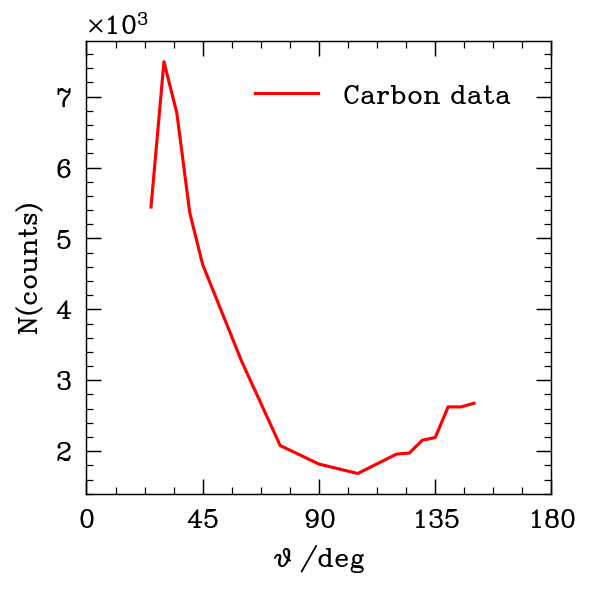

In [36]:
# plot experimental data
x = [] # thetas
y = [] # counts
z = [] # errors

with open('Carbonv2.csv') as File:  
    Line_reader = csv.reader(File, delimiter=',')
    for row in Line_reader:
        x.append(float(row[0]))
        y.append(float(row[1]))
        z.append(float(row[2]))
# line to cut out some data
x = x[0:]
y = y[0:]
z = z[0:]


fig, ax2 = plt.subplots(figsize=(4,4),dpi=150)

plt.plot(x,y,color='r',label="Carbon data")


ax2.set_xlabel(r'$\theta\;/\mathrm{deg}$')
ax2.set_ylabel(r'$N (counts)$')
# Set the Cartesian x-axis ticks to sensible values (in degrees).
ax2.set_xticks([0, 45, 90, 135, 180])
plt.legend()
plt.show()

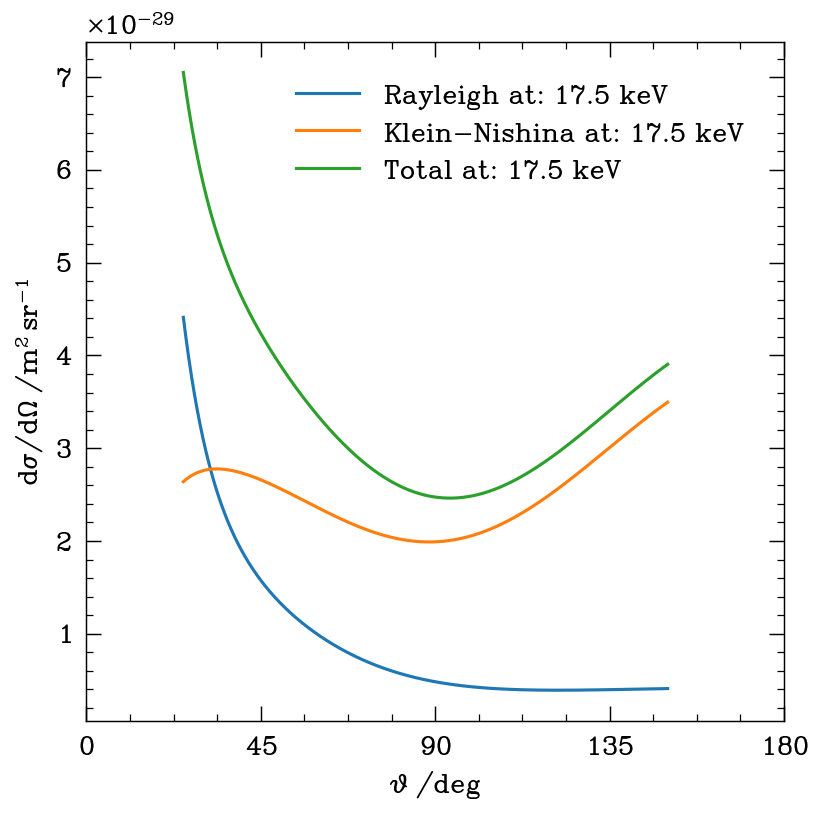

In [43]:
# plot the cross sections alone

fig, ax2 = plt.subplots(figsize=(6,6),dpi=150)

Z = 6

plot_diff_xsec(Z,E)

ax2.set_xlabel(r'$\theta\;/\mathrm{deg}$')
ax2.set_ylabel(r'$\mathrm{d}\sigma/\mathrm{d}\Omega\;/\mathrm{m^2\,sr^{-1}}$')
# Set the Cartesian x-axis ticks to sensible values (in degrees).
ax2.set_xticks([0, 45, 90, 135, 180])
plt.legend()
plt.show()

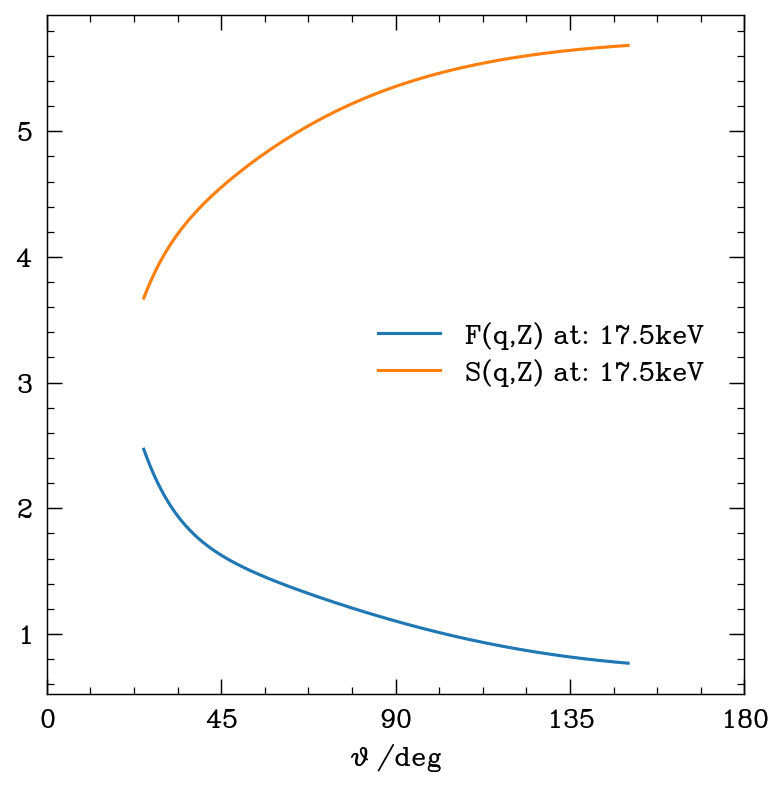

In [44]:
# plot the form-factors

fig, ax2 = plt.subplots(dpi=150)

Z = 6
Ek = 17.5

plt.plot(theta, F(theta,Z),label='F(q,Z) at: ' + str(Ek) + r'keV')
plt.plot(theta, S(theta,Z),label='S(q,Z) at: ' + str(Ek) + r'keV')


ax2.set_xlabel(r'$\theta\;/\mathrm{deg}$')
# Set the Cartesian x-axis ticks to sensible values (in degrees).
ax2.set_xticks([0, 45, 90, 135, 180])
plt.legend()
plt.show()

In [26]:
# calculate the chi-squared from data

# grab desired data
x = [] # thetas
y = [] # counts
z = [] # errors

with open('Carbonv2.csv') as File:  
    Line_reader = csv.reader(File, delimiter=',')
    for row in Line_reader:
        x.append(float(row[0]))
        y.append(float(row[1]))
        z.append(float(row[2]))
        
# line to cut out some data if so pleased
cutoff = 0
x = x[cutoff:]
y = y[cutoff:]
z = z[cutoff:]

# make a list of the predicted cross-sections from the angles
E = 0.0175
Z = 6

ExpectedXSecTotal = np.zeros(len(x))
ExpectedXSecKN = np.zeros(len(x))
ExpectedXSecR = np.zeros(len(x))
for i,b in enumerate(x):
    ExpectedXSecTotal[i] = KleinNishina(E,b)*S(b,Z) + Thompson(b)*(Fone(b,Z)**2)
    ExpectedXSecKN[i] = KleinNishina(E,b)*S(b,Z) 
    ExpectedXSecR[i] = Thompson(b)*(Fone(b,Z)**2)
    
    
y_err = z


def red_chi_2(l):
    red_chi = 0
    #print("Mark")
    for i,b in enumerate(y):
        #print("Obs: " + str(Obs[i]) + ", Exp Xsec: " + str(Exp[i]) + ", l: " + str(l) + ", Expected: " + str(l*Exp[i]))
        red_chi = red_chi + ((Obs[i] - l*Exp[i])**2)/(l*Exp[i])/(len(Obs)-1)
    return red_chi

Obs = y
Exp = ExpectedXSecTotal

resultTotal = opt.minimize_scalar(red_chi_2,1e+32,bounds=(1e31,1e33),method='bounded')

print("Total Chi = " + str(resultTotal.fun)) 
print("Total L = " + str(resultTotal.x))
print("\n")

Exp = ExpectedXSecKN

resultKN = opt.minimize_scalar(red_chi_2,1e+31,bounds=(3e20,4e34),method='bounded')

print("K-N Chi = " + str(resultKN.fun)) 
print("K-N L = " + str(resultKN.x))
print("\n")

Exp = ExpectedXSecR

resultR = opt.minimize_scalar(red_chi_2,1e+31,bounds=(3e20,4e34),method='bounded')

print("Rayleigh Chi = " + str(resultR.fun)) 
print("rayleigh L = " + str(resultR.x))
print("\n")

Total Chi = 276.49498111021586
Total L = 9.187522698013128e+31


K-N Chi = 953.8523642537169
K-N L = 1.4342954754051399e+32


Rayleigh Chi = 840.2981227901074
rayleigh L = 3.266584285892187e+32




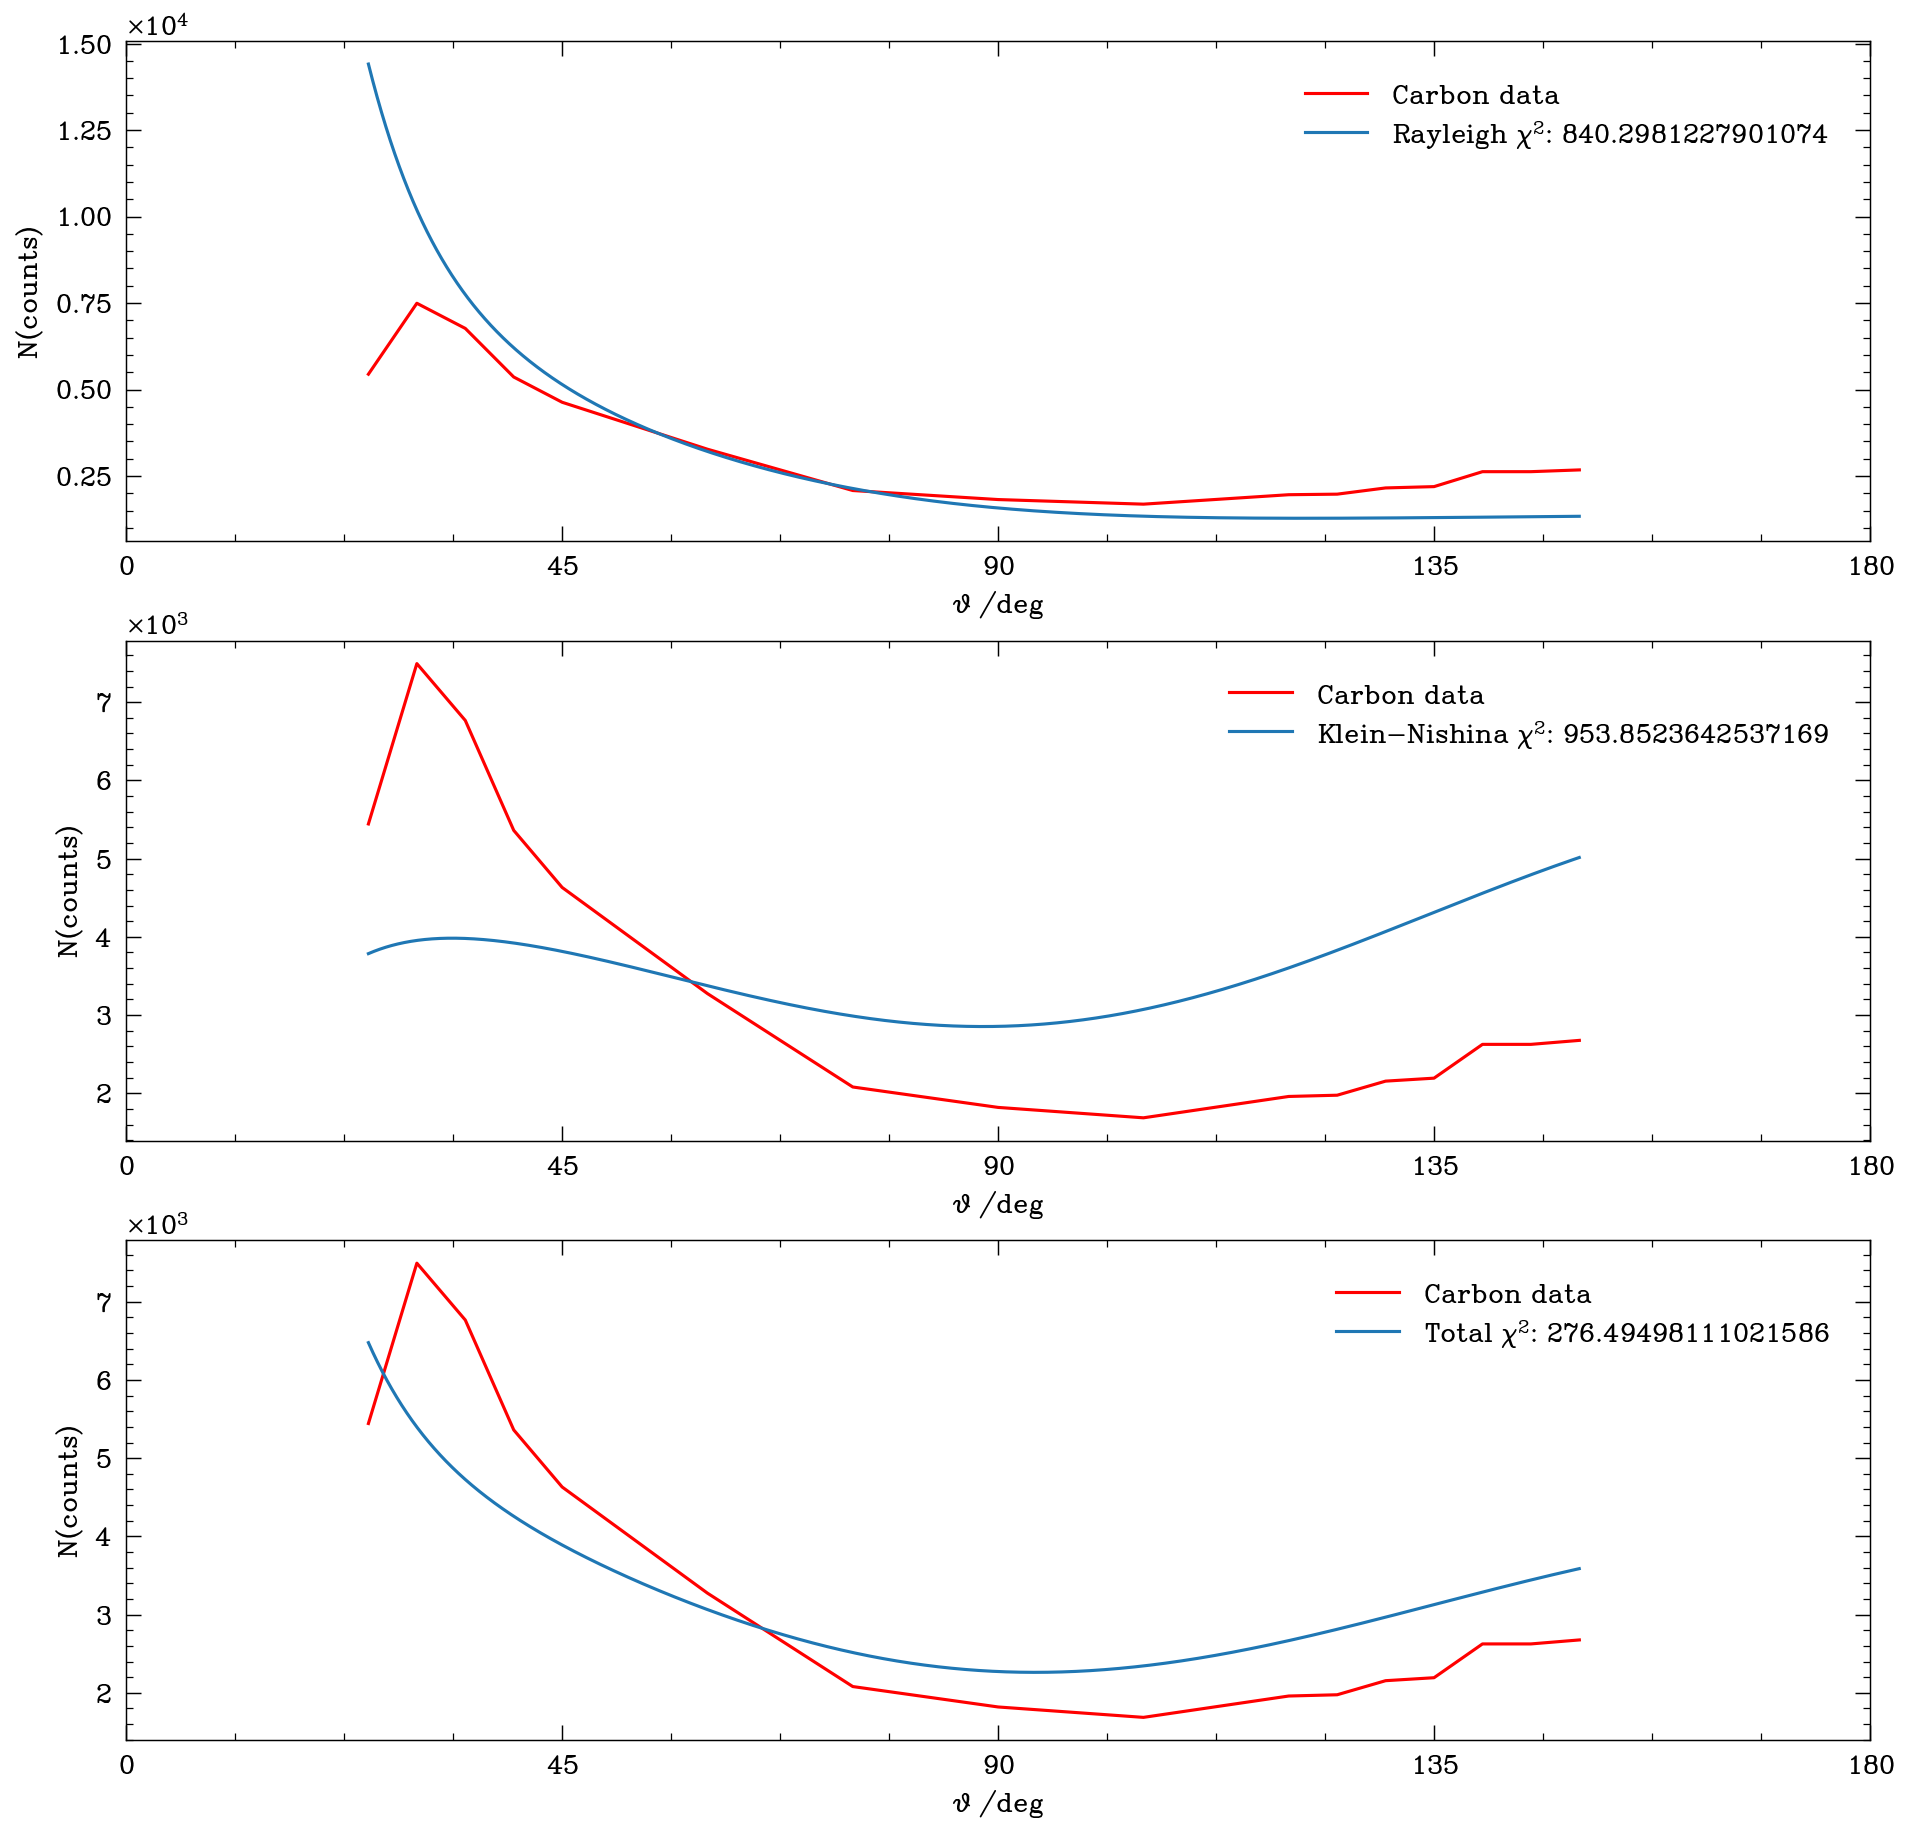

In [41]:
# plot the stupid graph

# plot experimental data
x = [] # thetas
y = [] # counts
z = [] # errors

with open('Carbonv2.csv') as File:  
    Line_reader = csv.reader(File, delimiter=',')
    for row in Line_reader:
        x.append(float(row[0]))
        y.append(float(row[1]))
        z.append(float(row[2]))
# line to cut out some data
x = x[0:]
y = y[0:]
z = z[0:]
Z = 6

fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(15,15),dpi=150)


ax1.plot(x,y,color='r',label="Carbon data")
ax2.plot(x,y,color='r',label="Carbon data")
ax3.plot(x,y,color='r',label="Carbon data")
theta, R, KN, Total = plot_counts(Z,E,resultTotal.x,resultR.x,resultKN.x)


# Plot Rayleigh.
ax1.plot(theta, R, label= 'Rayleigh $\chi^2$: ' + str(resultR.fun))   
# Plot Klein-Nishina
ax2.plot(theta, KN, label='Klein-Nishina $\chi^2$: ' + str(resultKN.fun))
# Plot the total csection
ax3.plot(theta, Total, label='Total $\chi^2$: ' + str(resultTotal.fun))

ax1.set_xlabel(r'$\theta\;/\mathrm{deg}$')
ax1.set_ylabel(r'$N (counts)$')
ax2.set_xlabel(r'$\theta\;/\mathrm{deg}$')
ax2.set_ylabel(r'$N (counts)$')
ax3.set_xlabel(r'$\theta\;/\mathrm{deg}$')
ax3.set_ylabel(r'$N (counts)$')
# Set the Cartesian x-axis ticks to sensible values (in degrees).
ax1.set_xticks([0, 45, 90, 135, 180])
ax1.legend()
ax2.set_xticks([0, 45, 90, 135, 180])
ax2.legend()
ax3.set_xticks([0, 45, 90, 135, 180])
ax3.legend()
plt.show()